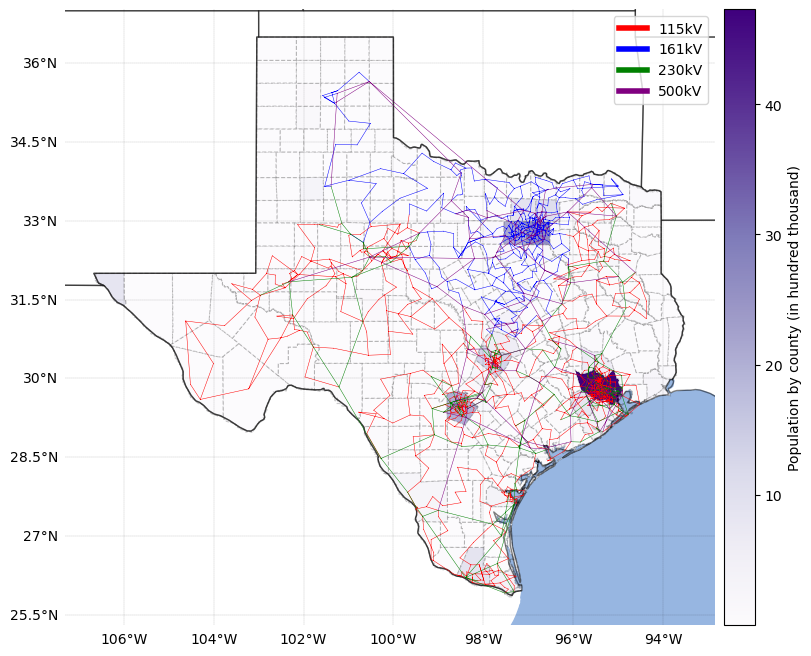

In [209]:
import geopandas as gpd
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Load the Texas county shapefile
tx_counties = gpd.read_file('County.shp')
# tx_counties = tx_counties[tx_counties['STATEFP'] == '48']

# Load the population data
pop_data = pd.read_csv('Tx_population.csv', dtype={'CNTY_NM': str, 'census_2020_count': int})
pop_data['census_2020_count'] = pop_data['census_2020_count']/1e5

# Merge the population data with the county shapefile
merged_data = tx_counties.merge(pop_data, on='CNTY_NM')

# Create the map
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.LAND, color='white')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor=(0, 0, 0, 0.5))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor=(0, 0, 0, 0.5))

merged_data.plot(column='census_2020_count', 
                 cmap='Purples', 
                 linewidth=0.8,
                 linestyle="--",
                 ax=ax, edgecolor=(0, 0, 0, 0.2), 
                 legend=True, 
                 legend_kwds={'label': "Population by county (in hundred thousand)", 
                              'orientation': "vertical", 'pad': 0.01})

# for hurricane and power system
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.09, color='black', linestyle='--')
gl.top_labels = False
gl.right_labels = False
# gl.ylabels_right = False
# gl.xlines = False
# gl.ylines = False



# # Note: the values for this should be an argument at some point
# gl.xlocator = mticker.FixedLocator([-107.5,-105.0,-102.5,-100.0,-97.5,-95.0,-92.5])
# gl.ylocator = mticker.FixedLocator([25,27.5,30.0,32.5,35.0,37.0])

custom_lines = [Line2D([0], [0], color=lines_colors[0], lw=4),
Line2D([0], [0], color=lines_colors[1], lw=4),
Line2D([0], [0], color=lines_colors[2], lw=4),
Line2D([0], [0], color=lines_colors[3], lw=4)]

for count, i in enumerate(lines_figlist):
    plt.plot(busdata['Longitude:1'][i[0][:]], busdata['Latitude:1'][i[0][:]], color=lines_colors[count], linewidth=0.35)
plt.legend(custom_lines, ['115kV', '161kV', '230kV', '500kV'])
# plt.title(hurricane_dataframe['time'][fig_idx].strftime("%Y-%m-%d_%H"))
ax.set_axis_off()
plt.show()

In [206]:
# READING IN DATA FOR BUSES AND LINES
# read in data and reduce columns

# read files
# FILES FOR THE POWER SYSTEMS MODEL
bus_data_filename = '../Texas2000busdata-BUS.txt'
line_data_filename = '../Texas2000busdata-LINES.txt'
substation_data_filename = '../Texas2000busdata-SUBSTATION_2.txt'

# BUSDATA
busdata_raw = pd.read_csv(bus_data_filename, sep='\s+' )
busdata = busdata_raw[['BusNum', 'BusName', 'Latitude:1', 'Longitude:1']]
busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
busdata = busdata.set_index('BusNum')
busdata = busdata.append(pd.Series(name=np.NaN))

# LINEDATA
linedata_raw = pd.read_csv(line_data_filename, sep='\s+' )
linedata = linedata_raw[['BusNum','BusNum:1']]
linedata = linedata.drop_duplicates().reset_index().drop('index', axis=1 )
linedata['NaN'] = np.NaN

# 'pairs' organizes transmission lines into stacked DataFrame in the form ->  FROM BusNum | TO BusNum:1
# NaN (to separate each pair)
pairs = linedata.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

longitudes = busdata['Longitude:1'][pairs[0][:]]
latitudes = busdata['Latitude:1'][pairs[0][:]]

# form a dataframe with connectivity status and corresponding voltage levels
linedata ['from(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum']],busdata['Latitude:1'][linedata['BusNum']]))
linedata ['to(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum:1']],busdata['Latitude:1'][linedata['BusNum:1']]))
busdata[:]['voltage']
volts = []
for i in linedata['BusNum']:
    volts.append(busdata['voltage'][i])
linedata['voltage'] = volts
    
# creates dataframes for each voltage level in grid
voltageI = linedata['voltage']
voltageI = [np.int16(x) for x in voltageI]
linedata['voltage'] = voltageI

linedata_ByVoltage = [1,2,3,4]

voltageLevels = np.unique(linedata['voltage'])
for i in range(len(voltageLevels)):
    df = linedata[linedata['voltage']==voltageLevels[i]]
    linedata_ByVoltage[i] = df.filter(items=['BusNum', 'BusNum:1', 'NaN'])
    
linedata_115kv = linedata_ByVoltage[0]
linedata_161kv = linedata_ByVoltage[1]
linedata_230kv = linedata_ByVoltage[2]
linedata_500kv = linedata_ByVoltage[3]


pairs115 = linedata_115kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs161 = linedata_161kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs230 = linedata_230kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs500 = linedata_500kv.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

# for plotting the figure list with colors
lines_figlist = [pairs115, pairs161, pairs230, pairs500]
lines_colors = ['red', 'blue', 'green', 'purple']

C:\Users\abodh.poudyal\AppData\Local\Temp\ipykernel_83208\3525869921.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
C:\Users\abodh.poudyal\AppData\Local\Temp\ipykernel_83208\3525869921.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  busdata = busdata.append(pd.Series(name=np.NaN))
C:\Users\abodh.poudyal\AppData\Local\Temp\ipykernel_83208\3525869921.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  busdata = busdata.append(pd.Series(name=np.NaN))
